In [341]:
# Datenstrukturen
import numpy as np
import pandas as pd

# Grafische Ausgabe
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons
# Some configuration of the plots we will create later
%matplotlib inline  
class_coloring = plt.cm.bwr

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression


import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

rnd_state = 888

# Datengenerierung

## Daten für die nichtlineare Klassifikation 

In [342]:
n_real_data = 500
X, y = make_moons(n_samples=n_real_data, noise=0.3, random_state=rnd_state)

## Synthetische Daten für die Schätzung des Interpretationsmodells
LIME erzeugt synthetische Daten unabhängig von der zu interpretierenden Instanz. Daher können die synthetischen Daten direkt zu beginn erzeugt werden. Dazu werden normalverteilte Daten zufällig gezogen.

In [343]:
n_syn_data =  500

mean_x = np.mean(X, axis=0)
s_x = np.std(X, axis=0)
np.random_state = rnd_state
X_syn = np.random.normal(loc=0, scale=1, size=n_syn_data*2).reshape(n_syn_data, 2)
X_syn = X_syn * s_x + mean_x

# Hilfsfunktionen für die grafische Darstellung

In [344]:
def plot_get_limits(D, delta=0.25):
    x1_lim = (np.min(D[:,0])-delta, np.max(D[:,0])+delta)
    x2_lim = (np.min(D[:,1])-delta, np.max(D[:,1])+delta)
    
    return (x1_lim, x2_lim)

In [345]:
def plot_init_axis(ax, title=None):
    
    if not title is None:
        ax.set_title(title, fontsize=16)
    ax.set_xlim(xy_limits[0][0], xy_limits[0][1])
    ax.set_ylim(xy_limits[1][0], xy_limits[1][1])
    ax.set_ylabel('$x_2$', fontsize=14)
    ax.set_xlabel('$x_1$', fontsize=14)

In [346]:
def plot_reg_line(ax, beta, bias, lw=5):
    # Plotting data
    x1 = np.linspace(xy_limits[0][0], xy_limits[0][1]) 
    x2 = - beta[0] / beta[1] * x1 - bias/beta[1]
    # Clipping
    ix = [i>xy_limits[1][0] and i < xy_limits[1][1] for i in x2]
    #ix = [i>x2_lim[0] and i < x2_lim[1] for i in x2]
    reg_line = np.c_[x1[ix], x2[ix]]
    # Plotting
    ax.plot(reg_line[:,0], reg_line[:,1], linewidth=lw, c='#FFFF00')
    return reg_line

In [347]:
def plot_data(ax, X, y, alpha=1, X_test=None, y_test=None):
    """ 2D Grafik des Klassifikationproblems"""
   
    # Plot the training & test points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=class_coloring, edgecolors='k', marker='o', alpha=alpha)
    #ax.set_xlabel("$x_1$")
    #ax.set_ylabel("$x_2$")
    if X_test is not None and y_test is not None:
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=class_coloring, edgecolors='k', marker='*', s=150, alpha=alpha)

In [348]:
def plot_synthetic(ax, X, y=None, weight=None, add_bar=False):
    """ 2D Grafik des Klassifikationproblems"""
    
    a = 0.7

    if y is None:
        ax.scatter(X[:,0], X[:,1], marker='^', c='k', s=weight, alpha=a)
    else:
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=class_coloring, edgecolors='k', marker='^', s=weight, alpha=a)

    if add_bar:
        ax_c = plt.colorbar(plt.cm.ScalarMappable(cmap=class_coloring))
        ax_c.set_label("BB-Modell Schätzung von $p(y=1|X)$")
        ax_c.set_ticks([0, .25, .5, .75, 1])
        

In [349]:
def mesh_grid_orig(model, res = 0.01, mode='classification'):
    res = 0.01 # step size in the mesh
   
    xx, yy = np.meshgrid( np.arange(xy_limits[0][0], xy_limits[0][1], res),
                          np.arange(xy_limits[1][0], xy_limits[1][1], res)
                        )   
    if mode == 'classification':
        y_hat = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    elif mode =='regression':
        y_hat = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    else:
        raise(BaseException('Der Modus {} wird nicht unterstützt.'.format(mode)))
    y_hat = y_hat.reshape(xx.shape)
    return (xx, yy, y_hat)

In [350]:
def mesh_grid_data(res = 0.01):
    
    xx, yy = np.meshgrid( np.arange(xy_limits[0][0], xy_limits[0][1], res),
                          np.arange(xy_limits[1][0], xy_limits[1][1], res)
                        )   
    
    return (xx, yy)

In [351]:
def mesh_grid_prediction(model, res = 0.01, mode='classification'):
   
    data = mesh_grid_data(res)
    
    if mode == 'classification':
        y_hat = clf.predict_proba(np.c_[data[0].ravel(), data[1].ravel()])[:, 1]
    elif mode =='regression':
        y_hat = clf.predict(np.c_[data[0].ravel(), data[1].ravel()])
    else:
        raise(BaseException('Der Modus {} wird nicht unterstützt.'.format(mode)))
    y_hat = y_hat.reshape(data[0].shape)
    return (data[0], data[1], y_hat)

In [352]:
def plot_decision_surface(ax, clf, data=None, add_bar=False, binarize=False):
    
    if data is None:
        x1, x2, y_hat = mesh_grid_prediction(clf)
    else:
        (x1, x2, y_hat) = data
        
    if binarize:
            y_hat = y_hat >= 0.5
            
    contour = ax.contourf(x1, x2, y_hat, cmap=class_coloring, alpha=.5) # , vmin=0, vmax=1
    
    if add_bar:
        ax_c = plt.gcf().colorbar(contour)
        ax_c.set_label("$P(y=1|X)$")
        ax_c.set_ticks([0, .25, .5, .75, 1])
        

In [353]:
def plot_instance(ax, xi=None):
    """ Grafische Darstellung der zu erklärenden Instanz"""
    if xi is None:
        xi = Xi
        
    ax.scatter(Xi[0,0], Xi[0,1], marker='o', c='#FFFF00', edgecolors='k' ,s=250)           

# Klassifikationsproblem

## Datengrundlage

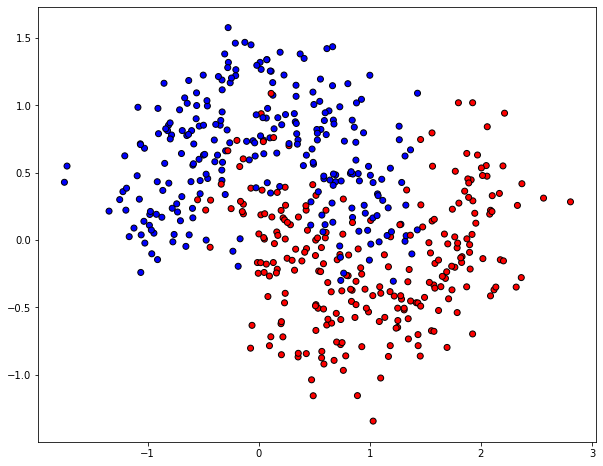

In [354]:
xy_limits = plot_get_limits( np.row_stack((X, X_syn)))

fig, ax = plt.subplots(figsize=(10, 8))
#plot_init_axis(ax, 'Synthetisches, nichtlinerares Klassifikationsproblem in 2D')
plot_data(ax, X, y)

## Training des nichtlineraren Klassifikators (BB-Modell)

In [355]:
# Klassifikator
#clf = XGBClassifier(learning_rate=0.01, n_estimators=250, random_state=rnd_state)
clf = MLPClassifier(hidden_layer_sizes=(100, 25), max_iter=500, random_state=rnd_state)
#clf = MLPClassifier(random_state=rnd_state)

BB_model = clf.fit(X, y)
y_syn = BB_model.predict_proba(X_syn)[:,1]

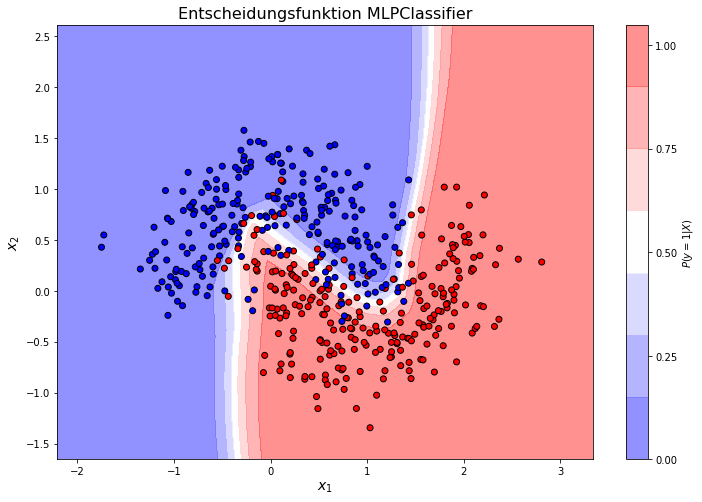

In [356]:
fig, ax = plt.subplots(figsize=(12,8))
plot_init_axis(ax, 'Entscheidungsfunktion {}'.format(type(BB_model).__name__))
plot_decision_surface(ax, BB_model, add_bar=True)
plot_data(ax, X, y)

# Lokale Interpretation mit LIME


## Zu erklärende Instanz festlegen

In [357]:
Xi = np.array([0.8, 0.5]).reshape(-1, 2)
p_Xi = BB_model.predict_proba(Xi).ravel()[1]
print('BB-Prognose der zu erklärenden Instanz ist: {:.4}'.format(p_Xi))

BB-Prognose der zu erklärenden Instanz ist: 0.03878


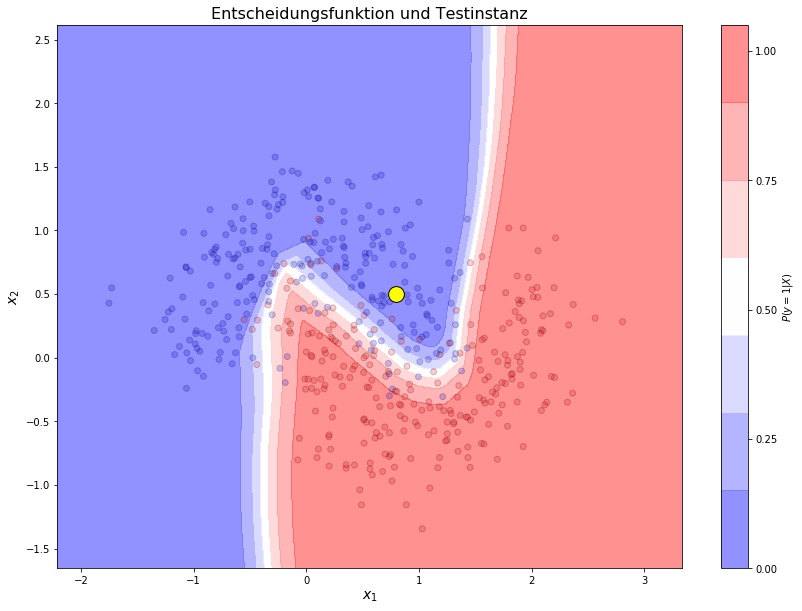

In [358]:
fig, ax = plt.subplots(figsize=(14,10))
plot_init_axis(ax, 'Entscheidungsfunktion und Testinstanz'.format(type(BB_model).__name__))
plot_decision_surface(ax, BB_model, add_bar=True)
plot_data(ax, X, y, alpha=.2)

# Instanz hinzufügen
plot_instance(ax)

## BB-Prognose in der Nachbarschaft von Xi

In [359]:
delta = 0.3
Xi_test = np.array(Xi+[delta, 0.0]).flatten()
ax.scatter(Xi_test[0], Xi_test[1], marker='o', c='#FFFF00', edgecolors='k' ,s=25);
ax.annotate('{:.3}'.format(clf.predict_proba(Xi_test.reshape(1,2))[0][1]), (Xi_test[0], Xi_test[1]), fontsize=14)
Xi_test = np.array(Xi+[0.0, delta]).flatten()
ax.scatter(Xi_test[0], Xi_test[1], marker='o', c='#FFFF00', edgecolors='k' ,s=25);
ax.annotate('{:.3}'.format(clf.predict_proba(Xi_test.reshape(1,2))[0][1]), (Xi_test[0], Xi_test[1]), fontsize=14)
Xi_test = np.array(Xi+[-delta, 0.0]).flatten()
ax.scatter(Xi_test[0], Xi_test[1], marker='o', c='#FFFF00', edgecolors='k' ,s=25);
ax.annotate('{:.3}'.format(clf.predict_proba(Xi_test.reshape(1,2))[0][1]), (Xi_test[0], Xi_test[1]), fontsize=14)
Xi_test = np.array(Xi+[0.0, -delta]).flatten()
ax.scatter(Xi_test[0], Xi_test[1], marker='o', c='#FFFF00', edgecolors='k' ,s=25);
ax.annotate('{:.3}'.format(clf.predict_proba(Xi_test.reshape(1,2))[0][1]), (Xi_test[0], Xi_test[1]), fontsize=14);

## Synthetische Daten und BB-Modellprognose 

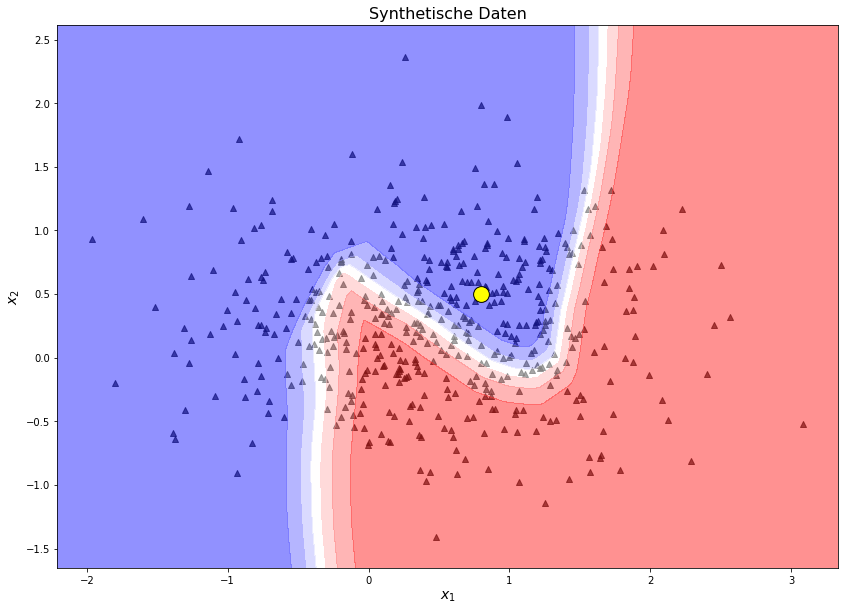

In [360]:
fig, ax = plt.subplots(figsize=(14,10))
plot_init_axis(ax, 'Synthetische Daten')
plot_synthetic(ax, X_syn)
plot_decision_surface(ax, BB_model)
plot_instance(ax)

## Nachbarschaft und Gewichtung 

### Berechnung der paarweisen Anstände zwischen synthetischen Daten und Testinstanz

In [361]:
distances = pairwise_distances(X_syn, Xi).ravel()
distances.shape

(500,)

### Kernfunktion

In [362]:
def kernel_fn(dist, kernel_width=0):
    if kernel_width == 0:
        kernel_width=np.sqrt(2) * 0.75
        
    return np.sqrt(np.exp(-(dist ** 2) / 0.5 ** 2))

sim = kernel_fn(distances)

### Datengrundlage für das Erklärungsmodell

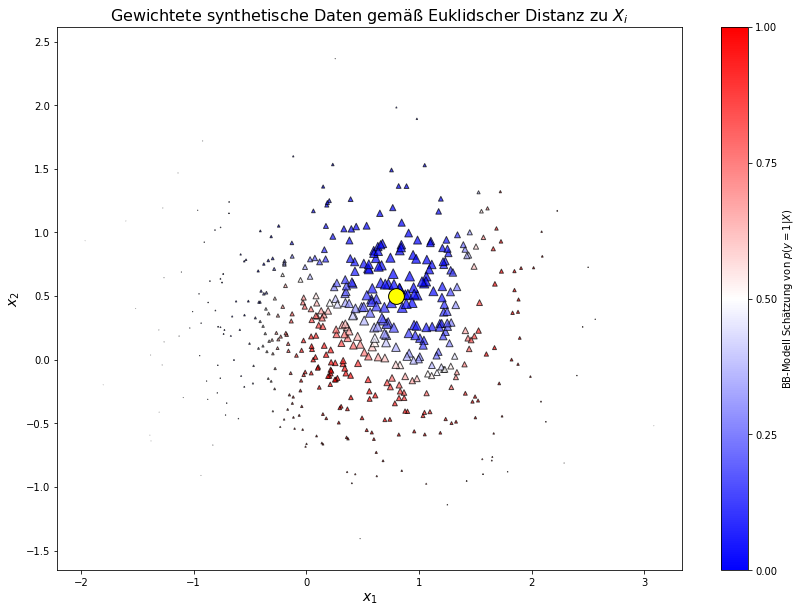

In [363]:
fig, ax = plt.subplots(figsize=(14,10))
plot_init_axis(ax, 'Gewichtete synthetische Daten gemäß Euklidscher Distanz zu $X_i$')
plot_synthetic(ax, X_syn, weight=sim*100, y=y_syn, add_bar=True)
plot_instance(ax)

Die Abbildung deutet bereits an, dass die Zielvariable eine bimodale Verteilung besitzt, was die Approximation des BB-Modells mit einer linearen Regression erschweren dürfte. Die problematische Verteilung zeigt auch folgendes Histogram.

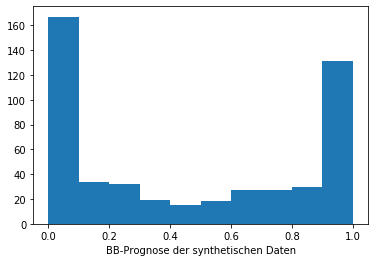

In [364]:
plt.hist(y_syn)
plt.xlabel('BB-Prognose der synthetischen Daten');


## Schätzung des Interpretationsmodells

In [365]:
#lin_reg = Ridge(alpha=1, fit_intercept=True)
lin_reg = LinearRegression(fit_intercept=True)
WB_model = lin_reg.fit(X_syn, y_syn, sample_weight=sim)
y_wb_syn = WB_model.predict(X_syn)

print('Parameter der linearen Regressionsfunktion: ', WB_model.coef_, reg_model.intercept_)

resid = y_syn - y_wb_syn 
print('Gewichtetet quadratischer Fehler = {:.4}'.format(np.sum((resid**2)*sim)/len(y_syn)))
print('Erklärte Varianz (ungewichtet) = {:.4}'.format(1-np.sum(resid**2)/np.sum((y_syn - np.mean(y_syn))**2)))

Parameter der linearen Regressionsfunktion:  [-0.14705289 -0.63404825] 0.5753440067182907
Gewichtetet quadratischer Fehler = 0.0166
Erklärte Varianz (ungewichtet) = 0.04338


## Ergebnis von LIME

Schätzung BB-Modell [0.03878213]
Schätzung Interpretationsmodell [0.25057195]


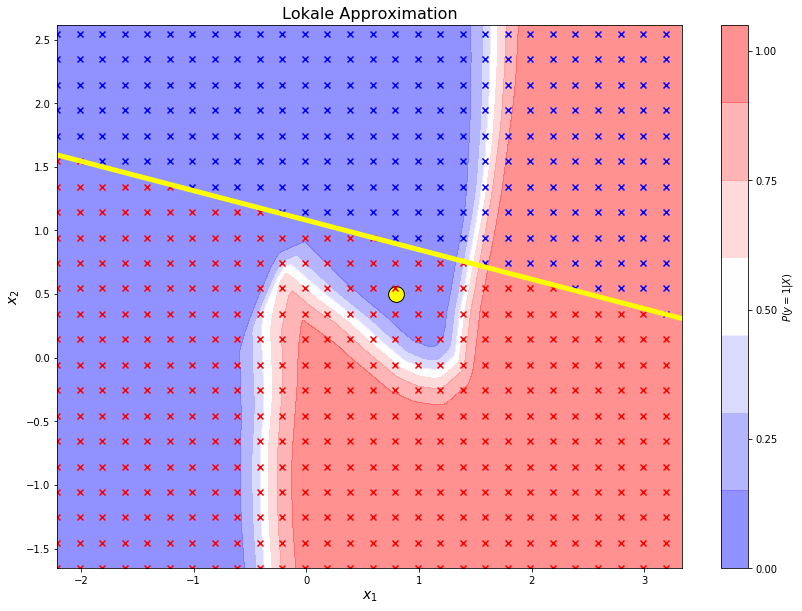

In [366]:
print('Schätzung BB-Modell {}'.format(BB_model.predict_proba(Xi)[:,1]))
print('Schätzung Interpretationsmodell {}'.format(WB_model.predict(Xi)))

# Ready to plot our hyperplane
fig, ax = plt.subplots(figsize=(14,10))
plot_init_axis(ax, 'Lokale Approximation')
plot_decision_surface(ax, BB_model, add_bar=True)
plot_reg_line(ax, beta=WB_model.coef_, bias = WB_model.intercept_)
plot_instance(ax)

data = mesh_grid_data(res=0.2)
data = np.c_[data[0].ravel(), data[1].ravel()]
y_hat = WB_model.predict(data)

ax.scatter(data[y_hat>0,0], data[y_hat>0,1], c='r', marker='x')
ax.scatter(data[y_hat<0,0], data[y_hat<0,1], c='b', marker='x')
plt.show();

## LIME Package

### Testinstanz erklären

In [367]:
import lime
from lime.lime_tabular import LimeTabularExplainer

# Create LIME explanation object for tab data
lime_explainer = LimeTabularExplainer(X, mode="classification", feature_names=['x1', 'x2'], categorical_features=None, verbose=True, discretize_continuous=False)

pred_fun = clf.predict_proba  # function which LIME can use to predict the synthetic data items
k=2

# Call the explanation function
exp_rf = lime_explainer.explain_instance(data_row=Xi.ravel(), predict_fn=pred_fun, num_features=k)
exp_rf.show_in_notebook(show_table=True, show_predicted_value= True)

Intercept 0.485150232586974
Prediction_local [0.36808296]
Right: 0.03878213117609575


### LIME Erklärungsmodell extrahieren

In [368]:
# Datenstruktur
print(exp_rf.local_exp)

# Beta extrahieren
xb=0
lime_beta=np.zeros(2)
for ix, tup in enumerate(exp_rf.local_exp[1]):
    xb += Xi[0][tup[0]] * tup[1]
    lime_beta[tup[0]]=tup[1]

# Lokale Prognose verifizieren    
xb+exp_rf.intercept[1] - exp_rf.local_pred[0]
#np.sum(lime_beta)+exp_rf.intercept[1] - exp_rf.local_pred[0]

{1: [(1, -0.3301156862899856), (0, 0.09206639543998524)]}


0.025662540975685766

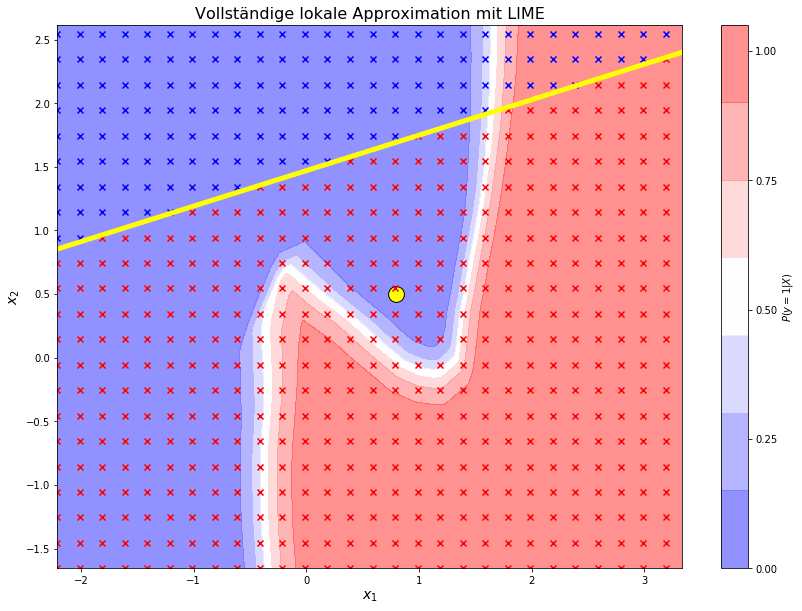

In [369]:
# Ready to plot our hyperplane
fig, ax = plt.subplots(figsize=(14,10))
plot_init_axis(ax, 'Vollständige lokale Approximation mit LIME')
plot_decision_surface(ax, BB_model, add_bar=True)
plot_reg_line(ax, beta=lime_beta, bias = exp_rf.intercept[1])
plot_instance(ax)

data = mesh_grid_data(res=0.2)
data = np.c_[data[0].ravel(), data[1].ravel()]
y_hat = np.dot(data, lime_beta.reshape(-1,1)) + exp_rf.intercept[1]
y_hat = y_hat.ravel()

ax.scatter(data[y_hat>0,0], data[y_hat>0,1], c='r', marker='x')
ax.scatter(data[y_hat<0,0], data[y_hat<0,1], c='b', marker='x')
plt.show();

In [370]:
# Klassifikator
# Testinstanz
# Kernel
# Stichprobenanzahl
# Noise im Klassifikationsproblem (ggf. sowie das Problem)